<a href="https://colab.research.google.com/github/sarankumarss166/Early_Prediction_of_Gastric_Cancer_using_Endoscopic_Images/blob/main/vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

# Paths
raw_path = '/content/drive/MyDrive/gi-endoscopy-project/data/raw/kvasir-dataset'
processed_path = '/content/drive/MyDrive/gi-endoscopy-project/data/processed'

# Final classes
final_classes = [
        'dyed-resection-margins',
            'esophagitis',
                'polyps',
                    'ulcerative-colitis',
                        'normal'
                                                ]

# Create folders for processed dataset
for cls in final_classes:
  os.makedirs(os.path.join(processed_path, cls), exist_ok=True)

# Merge data
for cls in os.listdir(raw_path):
  src_dir = os.path.join(raw_path, cls)
  if not os.path.isdir(src_dir):
    continue

  # If it's one of the 3 normal categories
  if cls.lower() in ['normal-cecum', 'normal-pylorus', 'normal-z-line']:
    dest_dir = os.path.join(processed_path, 'normal')
  elif cls.lower() in ['dyed-lifted-polyps','polyps']:
    dest_dir=os.path.join(processed_path, 'polyps')
  else:
    dest_dir = os.path.join(processed_path, cls)

  # Copy all images
  for file in os.listdir(src_dir):
    shutil.copy(os.path.join(src_dir, file), dest_dir)

print("Dataset reorganization complete!")

Dataset reorganization complete!


In [ ]:
import os
import shutil
import random

processed_path = '/content/drive/MyDrive/gi-endoscopy-project/data/processed'
split_base_path = '/content/drive/MyDrive/gi-endoscopy-project/data/split'

# Create train, val, test folders
for split in ['train', 'val', 'test']:
  for cls in os.listdir(processed_path):
      os.makedirs(os.path.join(split_base_path, split, cls), exist_ok=True)

# Split data
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

for cls in os.listdir(processed_path):
  cls_path = os.path.join(processed_path, cls)
  images = os.listdir(cls_path)
  random.shuffle(images)

  train_end = int(split_ratio['train'] * len(images))
  val_end = train_end + int(split_ratio['val'] * len(images))

  for i, img in enumerate(images):
    src = os.path.join(cls_path, img)
    if i < train_end:
      dest = os.path.join(split_base_path, 'train', cls, img)
    elif i < val_end:
      dest = os.path.join(split_base_path, 'val', cls, img)
    else:
      dest = os.path.join(split_base_path, 'test', cls, img)

    shutil.copy(src, dest)

print("Dataset split into train/val/test complete!")


Dataset split into train/val/test complete!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths for train/val/test folders
train_dir = '/content/drive/MyDrive/gi-endoscopy-project/data/split/train'
val_dir = '/content/drive/MyDrive/gi-endoscopy-project/data/split/val'
test_dir = '/content/drive/MyDrive/gi-endoscopy-project/data/split/test'

# Image size and batch size
IMG_SIZE = (224, 224)  # standard for most models like ResNet, VGG
BATCH_SIZE = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
        rotation_range=20,
            zoom_range=0.2,
                horizontal_flip=True
                                )
# Only rescale for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the iterators
train_generator = train_datagen.flow_from_directory(
  train_dir,
    target_size=IMG_SIZE,
      batch_size=BATCH_SIZE,
        class_mode='categorical'
        )


val_generator = val_datagen.flow_from_directory(
    val_dir,
      target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
          class_mode='categorical'
          )

test_generator = test_datagen.flow_from_directory(
    test_dir,
      target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
          class_mode='categorical',
            shuffle=False

)

Found 2807 images belonging to 5 classes.
Found 601 images belonging to 5 classes.
Found 602 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# 1️⃣ Build model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)  # 5 classes

model = Model(inputs=base_model.input, outputs=outputs)

# 2️⃣ Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
                            metrics=['accuracy'])

# 3️⃣ Checkpoint to save best model
checkpoint = ModelCheckpoint("/content/drive/MyDrive/gi-endoscopy-project/results2/vgg19_best.h5",
                             monitor='val_accuracy', save_best_only=True, mode='max')

# 4️⃣ Train for first 20 epochs
history_30 = model.fit(
    train_generator,
        validation_data=val_generator,
            epochs=30,
                batch_size=32,
                    callbacks=[checkpoint]
                    )

# 5️⃣ Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy after 30 epochs: {test_acc*100:.2f}%")
print(f"✅ Test Loss after 30 epochs: {test_loss:.4f}")

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.2799 - loss: 1.7236 

88/88 ━━━━━━━━━━━━━━━━━━━━ 1305s 15s/step - accuracy: 0.2803 - loss: 1.7224 - val_accuracy: 0.4043 - val_loss: 1.3988
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.3824 - loss: 1.4748

88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 895ms/step - accuracy: 0.3825 - loss: 1.4746 - val_accuracy: 0.4642 - val_loss: 1.3176
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.4351 - loss: 1.3935

88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 894ms/step - accuracy: 0.4353 - loss: 1.3931 - val_accuracy: 0.5191 - val_loss: 1.2026
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 78s 855ms/step - accuracy: 0.4747 - loss: 1.2961 - val_accuracy: 0.5075 - val_loss: 1.1330
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.4875 - loss: 1.2204

88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 855ms/step - accuracy: 0.4877 - loss: 1.2202 - val_accuracy: 0.5341 - val_loss: 1.0583
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.5082 - loss: 1.1626

88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 860ms/step - accuracy: 0.5082 - loss: 1.1624 - val_accuracy: 0.5358 - val_loss: 1.0291
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.5209 - loss: 1.1033

88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 857ms/step - accuracy: 0.5209 - loss: 1.1033 - val_accuracy: 0.5424 - val_loss: 0.9806
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.5171 - loss: 1.0834

88/88 ━━━━━━━━━━━━━━━━━━━━ 77s 867ms/step - accuracy: 0.5171 - loss: 1.0832 - val_accuracy: 0.5607 - val_loss: 0.9481
Epoch 9/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.5403 - loss: 1.0359

88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 865ms/step - accuracy: 0.5402 - loss: 1.0359 - val_accuracy: 0.5740 - val_loss: 0.9296
Epoch 10/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.5469 - loss: 1.0256

88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 866ms/step - accuracy: 0.5470 - loss: 1.0254 - val_accuracy: 0.5790 - val_loss: 0.9032
Epoch 11/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.5813 - loss: 0.9669

88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 846ms/step - accuracy: 0.5812 - loss: 0.9670 - val_accuracy: 0.6156 - val_loss: 0.8644
Epoch 12/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.5772 - loss: 0.9623

88/88 ━━━━━━━━━━━━━━━━━━━━ 77s 877ms/step - accuracy: 0.5771 - loss: 0.9623 - val_accuracy: 0.6206 - val_loss: 0.8491
Epoch 13/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 841ms/step - accuracy: 0.5829 - loss: 0.9497 - val_accuracy: 0.6173 - val_loss: 0.8289
Epoch 14/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 828ms/step - accuracy: 0.6161 - loss: 0.8889 - val_accuracy: 0.6140 - val_loss: 0.8165
Epoch 15/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.6146 - loss: 0.8848

88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 842ms/step - accuracy: 0.6145 - loss: 0.8849 - val_accuracy: 0.6606 - val_loss: 0.7876
Epoch 16/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.6261 - loss: 0.8731

88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 857ms/step - accuracy: 0.6262 - loss: 0.8730 - val_accuracy: 0.6722 - val_loss: 0.7762
Epoch 17/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 840ms/step - accuracy: 0.6352 - loss: 0.8528 - val_accuracy: 0.6622 - val_loss: 0.7615
Epoch 18/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.6490 - loss: 0.8384

88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 871ms/step - accuracy: 0.6490 - loss: 0.8385 - val_accuracy: 0.7038 - val_loss: 0.7328
Epoch 19/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 840ms/step - accuracy: 0.6351 - loss: 0.8257 - val_accuracy: 0.6905 - val_loss: 0.7430
Epoch 20/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 820ms/step - accuracy: 0.6454 - loss: 0.8143 - val_accuracy: 0.6955 - val_loss: 0.7269
Epoch 21/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.6688 - loss: 0.7833

88/88 ━━━━━━━━━━━━━━━━━━━━ 77s 871ms/step - accuracy: 0.6688 - loss: 0.7835 - val_accuracy: 0.7155 - val_loss: 0.6990
Epoch 22/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 840ms/step - accuracy: 0.6579 - loss: 0.7841 - val_accuracy: 0.7105 - val_loss: 0.6914
Epoch 23/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 839ms/step - accuracy: 0.6852 - loss: 0.7577 - val_accuracy: 0.6972 - val_loss: 0.6900
Epoch 24/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.6901 - loss: 0.7511

88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 856ms/step - accuracy: 0.6899 - loss: 0.7513 - val_accuracy: 0.7221 - val_loss: 0.6735
Epoch 25/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 865ms/step - accuracy: 0.6786 - loss: 0.7521 - val_accuracy: 0.7005 - val_loss: 0.6816
Epoch 26/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 827ms/step - accuracy: 0.6788 - loss: 0.7339 - val_accuracy: 0.7038 - val_loss: 0.6942
Epoch 27/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.6867 - loss: 0.7316

88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 858ms/step - accuracy: 0.6866 - loss: 0.7317 - val_accuracy: 0.7288 - val_loss: 0.6599
Epoch 28/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 77s 871ms/step - accuracy: 0.6997 - loss: 0.7209 - val_accuracy: 0.7221 - val_loss: 0.6434
Epoch 29/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.6958 - loss: 0.7072

88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 860ms/step - accuracy: 0.6959 - loss: 0.7072 - val_accuracy: 0.7454 - val_loss: 0.6302
Epoch 30/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 0.7022 - loss: 0.7246 - val_accuracy: 0.7205 - val_loss: 0.6391
19/19 ━━━━━━━━━━━━━━━━━━━━ 275s 15s/step - accuracy: 0.6935 - loss: 0.6669
✅ Test Accuracy after 30 epochs: 74.25%
✅ Test Loss after 30 epochs: 0.6241


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 1️⃣ Checkpoint to save best model again
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/gi-endoscopy-project/results2/vgg19_best.h5",
        monitor='val_accuracy',
            save_best_only=True,
                mode='max'
                )

# 2️⃣ Continue training for next 10 epochs (from epoch 30 → 40)
history = model.fit(train_generator,
        validation_data=val_generator,
                            initial_epoch=30,   # 👈 tells Keras we already trained 30 epochs
                                epochs=40,          # total epochs
                                    callbacks=[checkpoint]
                                    )

# 3️⃣ Evaluate again on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy after 40 epochs: {test_acc*100:.2f}%")
print(f"✅ Test Loss after 40 epochs: {test_loss:.4f}")


Epoch 31/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.6958 - loss: 0.7121

88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 852ms/step - accuracy: 0.6959 - loss: 0.7119 - val_accuracy: 0.7371 - val_loss: 0.6191
Epoch 32/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.7148 - loss: 0.6905

88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 851ms/step - accuracy: 0.7148 - loss: 0.6903 - val_accuracy: 0.7421 - val_loss: 0.6302
Epoch 33/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.7145 - loss: 0.6837

88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 854ms/step - accuracy: 0.7146 - loss: 0.6835 - val_accuracy: 0.7454 - val_loss: 0.6063
Epoch 34/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 837ms/step - accuracy: 0.7054 - loss: 0.6936 - val_accuracy: 0.7438 - val_loss: 0.6144
Epoch 35/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.7180 - loss: 0.6872

88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 836ms/step - accuracy: 0.7180 - loss: 0.6870 - val_accuracy: 0.7504 - val_loss: 0.6063
Epoch 36/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 838ms/step - accuracy: 0.7064 - loss: 0.6850 - val_accuracy: 0.7038 - val_loss: 0.6308
Epoch 37/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.7409 - loss: 0.6274

88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 830ms/step - accuracy: 0.7408 - loss: 0.6277 - val_accuracy: 0.7587 - val_loss: 0.5809
Epoch 38/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 849ms/step - accuracy: 0.7218 - loss: 0.6660 - val_accuracy: 0.7537 - val_loss: 0.5854
Epoch 39/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 819ms/step - accuracy: 0.7350 - loss: 0.6370 - val_accuracy: 0.7504 - val_loss: 0.5859
Epoch 40/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 850ms/step - accuracy: 0.7309 - loss: 0.6615 - val_accuracy: 0.7404 - val_loss: 0.5922


NameError: name 'test_ds' is not defined

In [ ]:

# 3️⃣ Evaluate again on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy after 40 epochs: {test_acc*100:.2f}%")
print(f"✅ Test Loss after 40 epochs: {test_loss:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 388ms/step - accuracy: 0.6903 - loss: 0.6513
✅ Test Accuracy after 40 epochs: 75.25%
✅ Test Loss after 40 epochs: 0.5771


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# ✅ Continue for 5 more epochs (total 45)
checkpoint_more = ModelCheckpoint(
    "/content/drive/MyDrive/gi-endoscopy-project/results2/vgg19_best.h5",
        monitor='val_accuracy',
            save_best_only=True,
                mode='max'
                )

history_more = model.fit(
                    train_generator,
                        epochs=50,   # since you already trained till 40
                            initial_epoch=40,   # resume from 40
                                validation_data=val_generator,
                                    callbacks=[checkpoint_more]
                                    )

# 🎯 Evaluate after 50 epochs
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy after 50 epochs: {test_acc*100:.2f}%")
print(f"✅ Test Loss after 50 epochs: {test_loss:.4f}")


Epoch 41/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.7189 - loss: 0.6649

88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 893ms/step - accuracy: 0.7190 - loss: 0.6648 - val_accuracy: 0.7404 - val_loss: 0.6004
Epoch 42/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.7401 - loss: 0.6261

88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 861ms/step - accuracy: 0.7401 - loss: 0.6260 - val_accuracy: 0.7687 - val_loss: 0.5585
Epoch 43/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 840ms/step - accuracy: 0.7306 - loss: 0.6436 - val_accuracy: 0.7438 - val_loss: 0.5956
Epoch 44/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 832ms/step - accuracy: 0.7180 - loss: 0.6431 - val_accuracy: 0.7471 - val_loss: 0.5942
Epoch 45/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 857ms/step - accuracy: 0.7380 - loss: 0.6321 - val_accuracy: 0.7571 - val_loss: 0.5626
Epoch 46/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 828ms/step - accuracy: 0.7473 - loss: 0.6112 - val_accuracy: 0.7537 - val_loss: 0.5783
Epoch 47/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 835ms/step - accuracy: 0.7371 - loss: 0.6217 - val_accuracy: 0.7554 - val_loss: 0.5587
Epoch 48/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 835ms/step - accuracy: 0.7417 - loss: 0.6252 - val_accuracy: 0.7521 - val_loss: 0.5614
Epoch 49/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 85s 874ms/step - accuracy: 0.7563 - loss: 0.6015 - val_accuracy

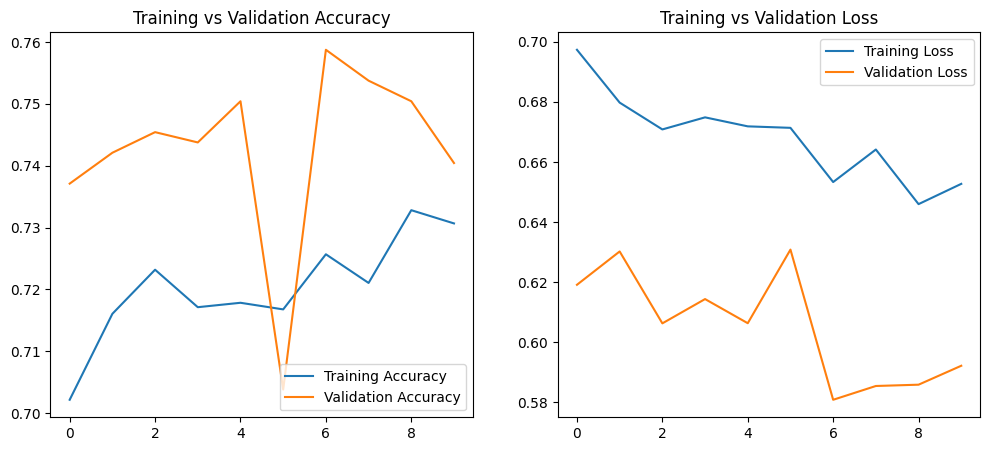

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is your training history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


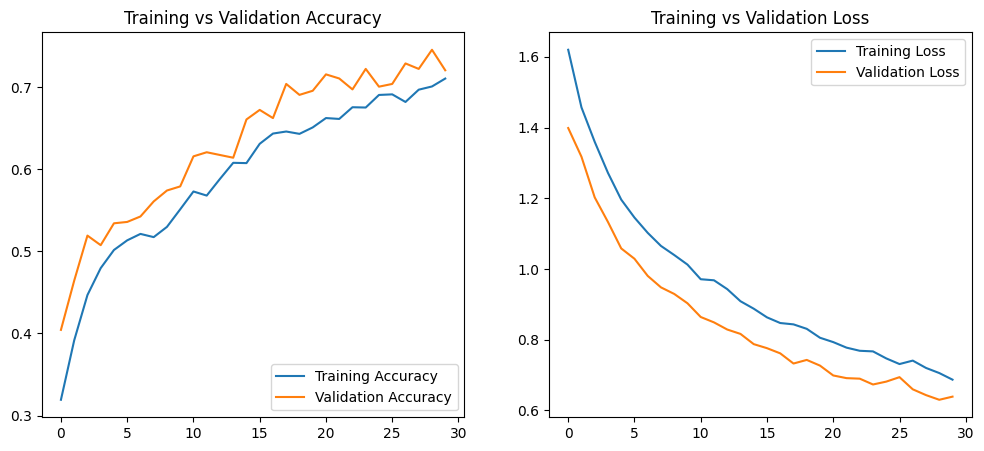

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is your training history object
acc = history_30.history['accuracy']
val_acc = history_30.history['val_accuracy']
loss = history_30.history['loss']
val_loss = history_30.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


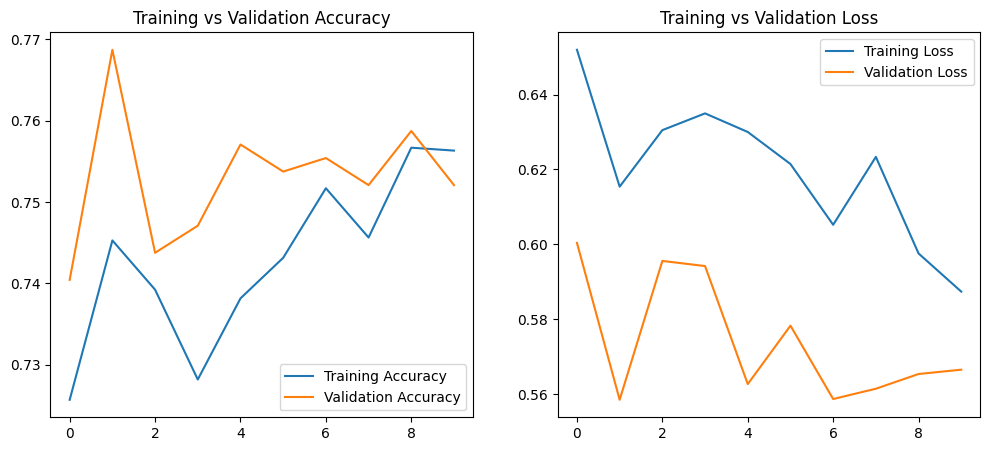

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is your training history object
acc = history_more.history['accuracy']
val_acc = history_more.history['val_accuracy']
loss = history_more.history['loss']
val_loss = history_more.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step


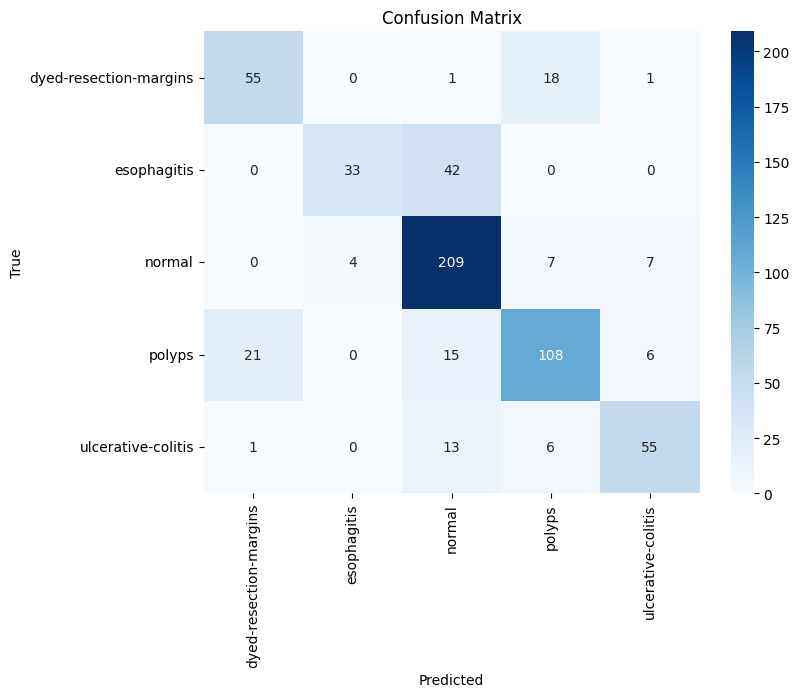

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
                        yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes,
                            target_names=list(test_generator.class_indices.keys())))


Classification Report:

                        precision    recall  f1-score   support

dyed-resection-margins       0.71      0.73      0.72        75
           esophagitis       0.89      0.44      0.59        75
                normal       0.75      0.92      0.82       227
                polyps       0.78      0.72      0.75       150
    ulcerative-colitis       0.80      0.73      0.76        75

              accuracy                           0.76       602
             macro avg       0.79      0.71      0.73       602
          weighted avg       0.77      0.76      0.76       602



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


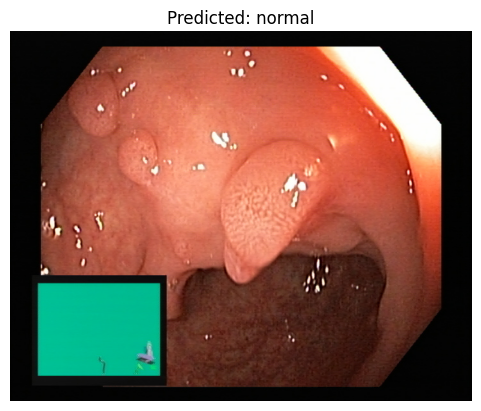

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


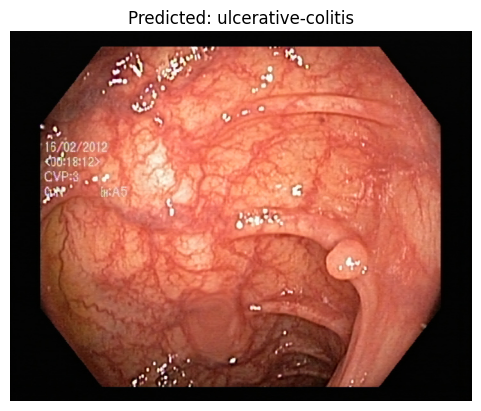

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


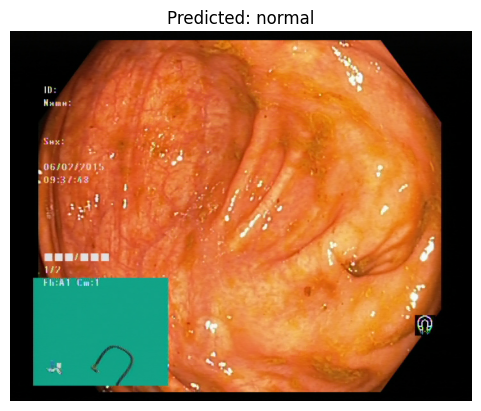

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


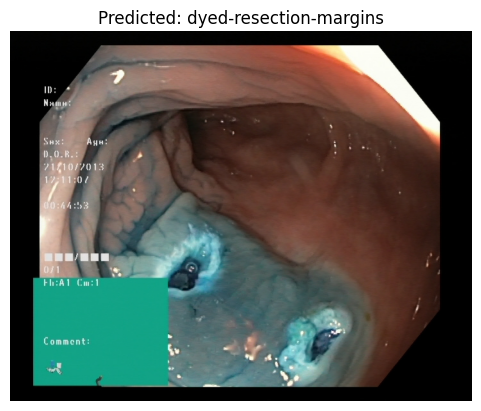

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


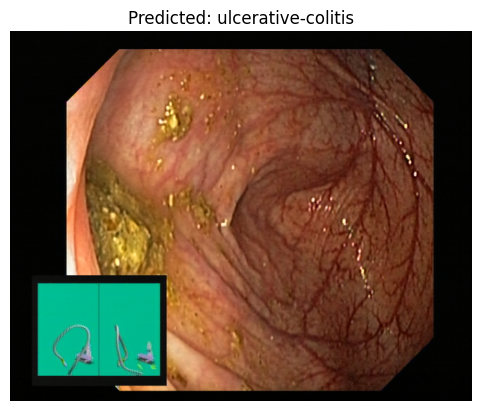

In [ ]:
import random
from tensorflow.keras.preprocessing import image

# Pick 5 random test images
for i in range(5):
  idx = random.randint(0, len(test_generator.filenames)-1)
  img_path = test_generator.filepaths[idx]
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)/255.0
  img_array = np.expand_dims(img_array, axis=0)

  pred = model.predict(img_array)
  pred_class = np.argmax(pred)

  plt.imshow(image.load_img(img_path))
  plt.title(f"Predicted: {list(test_generator.class_indices.keys())[pred_class]}")
  plt.axis("off")
  plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


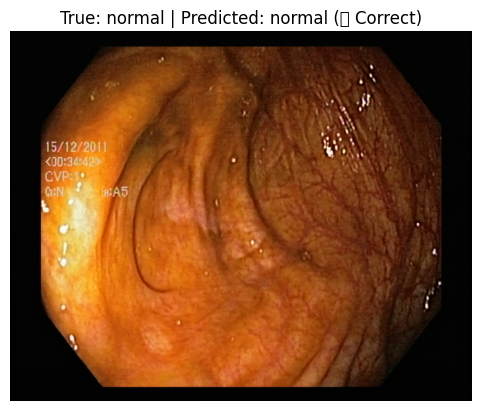

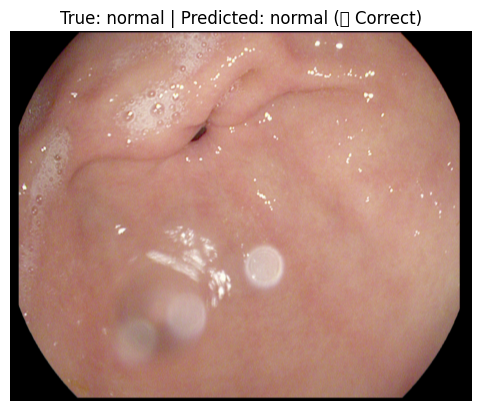

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


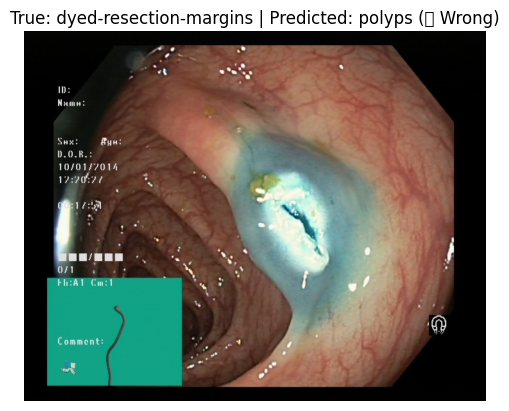

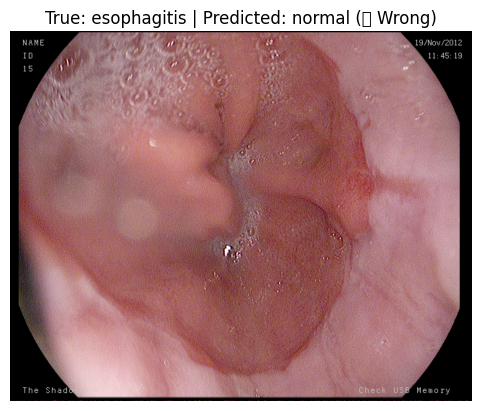

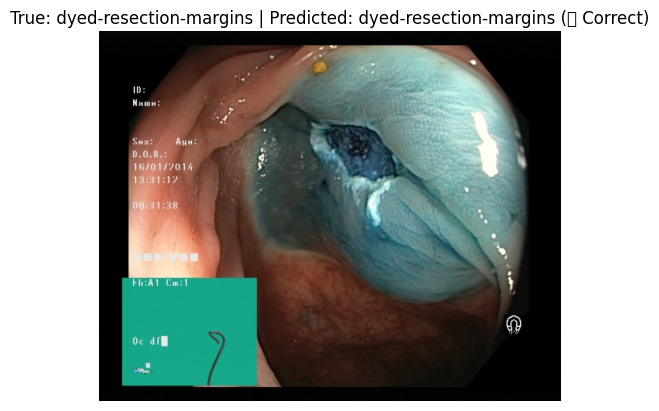

In [ ]:
import random
from tensorflow.keras.preprocessing import image

# Get mapping of class indices → class names
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}

# Pick 5 random test images
for i in range(5):
  idx = random.randint(0, len(test_generator.filenames)-1)
  img_path = test_generator.filepaths[idx]

  # Load and preprocess image
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)

  # Prediction
  pred = model.predict(img_array, verbose=0)
  pred_class = np.argmax(pred)

  # True label
  true_class = test_generator.classes[idx]

  # Compare
  result = "✅ Correct" if pred_class == true_class else "❌ Wrong"

  # Show image with both labels
  plt.imshow(image.load_img(img_path))
  plt.title(f"True: {idx_to_class[true_class]} | Predicted: {idx_to_class[pred_class]} ({result})")
  plt.axis("off")
  plt.show()

/tmp/ipython-input-2584126798.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2584126798.py:41: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


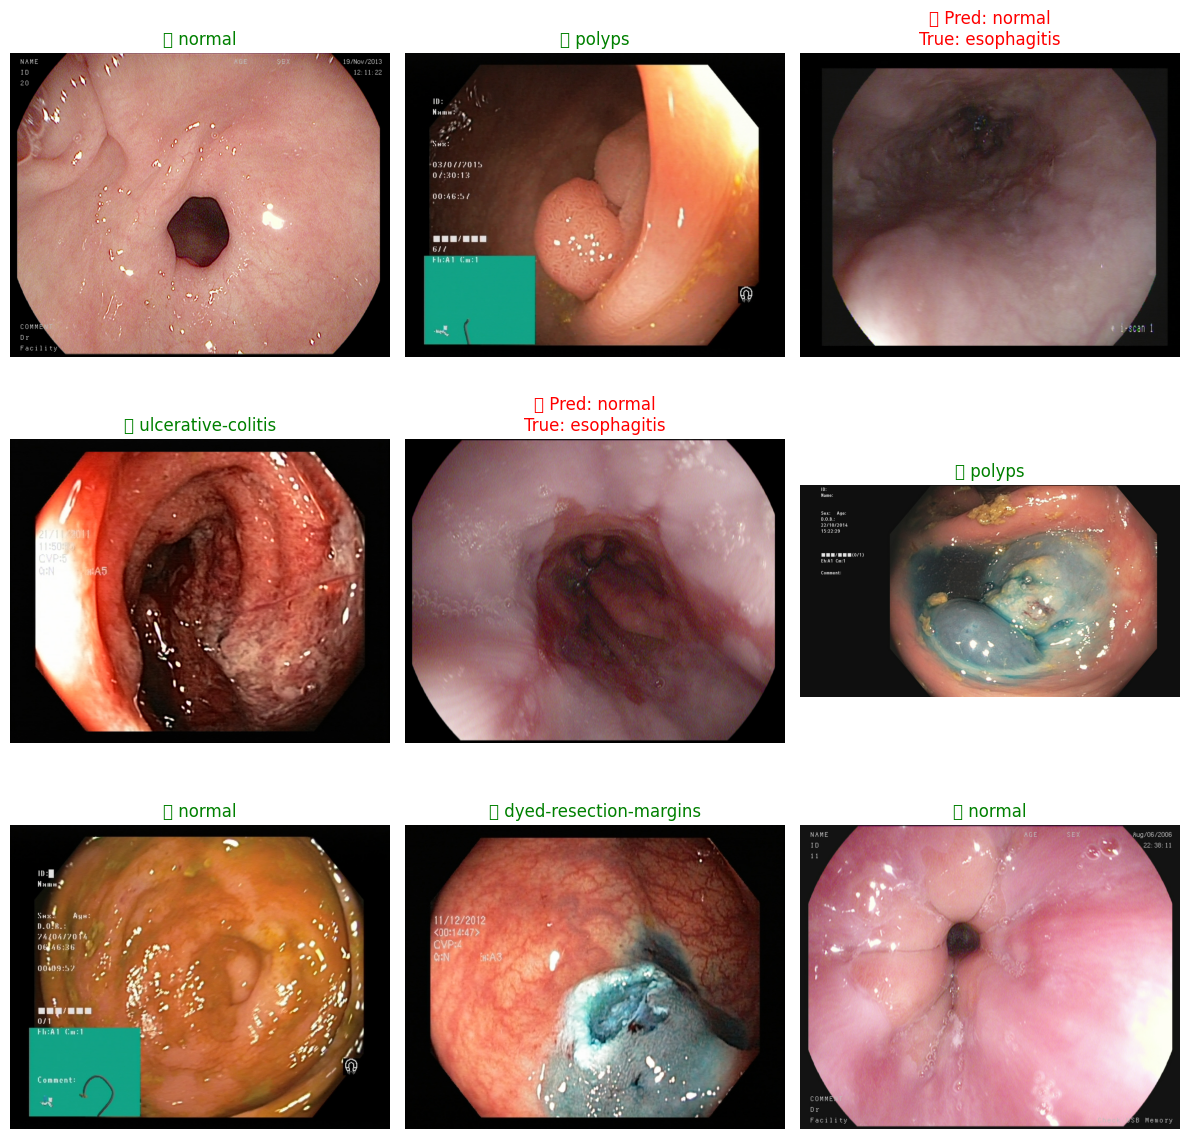

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Pick 9 random test images
plt.figure(figsize=(12, 12))

for i in range(9):
  idx = random.randint(0, len(test_generator.filenames)-1)
  img_path = test_generator.filepaths[idx]

  # True label
  true_class = img_path.split("/")[-2]  # folder name is true label

  # Load and preprocess image
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)

  # Predict
  pred = model.predict(img_array, verbose=0)
  pred_class = class_labels[np.argmax(pred)]

  # Plot
  plt.subplot(3, 3, i+1)
  plt.imshow(image.load_img(img_path))
  if pred_class == true_class:
    color = "green"
    title = f"✅ {pred_class}"
  else:
    color = "red"
    title = f"❌ Pred: {pred_class}\nTrue: {true_class}"

  plt.title(title, color=color, fontsize=12)
  plt.axis("off")

plt.tight_layout()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 451ms/step


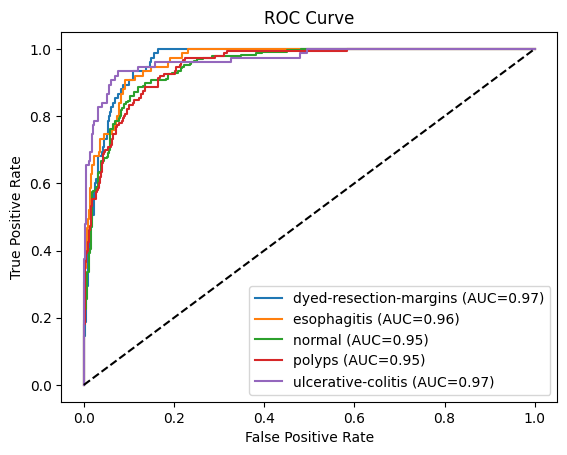

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# One-hot encode true labels
y_true_bin = label_binarize(y_true, classes=range(len(test_generator.class_indices)))
y_pred_prob = model.predict(test_generator)

for i, class_name in enumerate(test_generator.class_indices.keys()):
  fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'{class_name} (AUC={roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
